In [1]:
# We import some helpful stuff
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

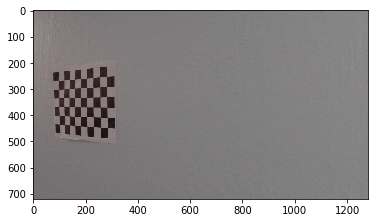

In [2]:
# We read in and display a calibration image
img = cv2.imread('camera_cal/calibration11.jpg')
plt.imshow(img)

In [3]:
# We create an array to hold the 2D image points of our calibration image
# and one to hold the 3D object points of the real world object (that is, the chessboard)
imgpoints = []
objpoints = []

In [4]:
# We ask np.zeros for a 6x9 matrix that has 3 points at every point (for x, y, & z)
# Yet z is = 0 at every point of the real world object
# Thus, we prepare object points thusly: (0,0,0), (1,0,0), (2,0,0)... (8,5,0)
objp = np.zeros((6*9, 3), np.float32)
# We then use np.mgrid to generate coordinates
# for the first two columns of objp (that is, x and y)
# for our grid of size 9, 6 and then shape them into
# a matrix of two columns
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

In [5]:
# To procure the image points, we use cv2.findChessboardCorners()
# on our 9 x 6 chessboard image (None refers to any flags)
# after moving the image to the Grayscale color space
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

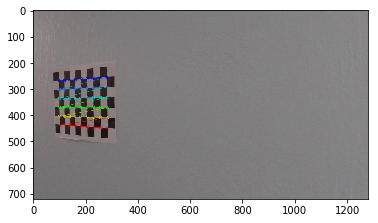

In [6]:
# If corners are found...
if ret == True:
    # append them to the image point array
    imgpoints.append(corners)
    # and append objp (created above) to the object point array
    objpoints.append(objp)
    # (Note: because objp is the ideal reference,
    # it will be compared to all of our calibration images)
    
    # Then draw the corners on our original, non-grayscale img
    # and display the image
    img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
    plt.imshow(img)

In [7]:
# So, there's an interesting-ish thing going on...
#
# It seems drawChessboardCorners() is very sensitive
# to the size of matrix one is looking for.
# If the user doesn't specify precisely the matrix
# size that the function is able to locate in gray, it returns None for corners
# (No wonder checking if ret == True is the logic token of choice here)
#
# For example, with calibration6.jpg, it only works if I specify a (9,6) matrix,
# whereas for calibration5.jpg, the system demands a matrix of size (7,6) to work.
#
# I guess I could just quickly try all options in the 9x6 range...
# But I'd really rather just hardcode a working solution.
#
# There's a further issue: which is that the calibration images
# that Udacity has provided me with can qualitatively be divided into two groups: 
# calibration1 - calibration5 are very different from calibration6 - calibration20
# not only aesthetically / visually, but also in regards to proximity to the chessboard;
# the latter group doesn't crop any of the edges in the way the former group does.
#
# And since I've just decided I'm lazy enough to want a hardcoded option
# I may be effectively cutting myself off from 1/4th of the data.
# This concerns me, as Cezanne said we wanted a minimum of 20 calibration images, ideally...
#
# Update: while checking the OpenCV docs for calibrateCamera(), I came across this statement: 
# "For better results, we need at least 10 test patterns." 
# So, it seems we're good with just 14 images (6 - 20)...
#

In [8]:
# So, we read in all the calibration images via the glob API, which we import
import glob

images = glob.glob('camera_cal/calibration*.jpg')
# Note: we are only able to use the wildcard * above because we have already
# removed calibration1.jpg - calibration5.jpg from the camera_cal folder

In [9]:
# This time around, let's make our chessboard dimension sizes into variables
board_x = 9
board_y = 6

In [10]:
# And let's redo the creation of imgpoints, objpoints, and objp
# just to be sure our results work with the new settings variables...
imgpoints = []
objpoints = []
objp = np.zeros((board_y*board_x, 3), np.float32)
objp[:,:2] = np.mgrid[0:board_x,0:board_y].T.reshape(-1,2)

In [11]:
# Then we iterate through the images, and apply the process developed above
for fname in images:
    # Read in image
    img = cv2.imread(fname)
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Find corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)
    # If corners are found...
    if ret == True:
        # append them to the image point array
        imgpoints.append(corners)
        # and append objp (created above) to the object point array
        objpoints.append(objp)
        # (Note: because objp is the ideal reference,
        # it will be compared to all of our calibration images)    

In [12]:
# With all our sets of calibration image points, and identical sets of ideal object points,
# we are ready to feed them into cv2.calibrateCamera()
# Note: mtx is our (3D -> 2D) Camera matrix, and dist our distortion coefficients
# both of which we need to transform 3D object points to 2D image points.
# rvecs and tvecs are the rotation and translation vectors that describe the camera's
# location in the world, which calibrateCamera also returns.
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[1::-1], None, None)


In [13]:
# We now go about applying cv2.undistort() with our long-sought mtx and dist.
# We start testing by applying it to one of our calibration images, 
# which we first load and display:

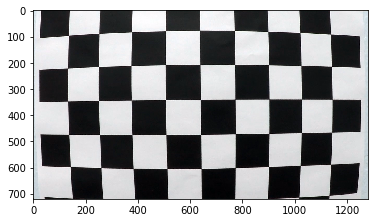

In [14]:
img = cv2.imread('camera_cal_unused/calibration1.jpg')
plt.imshow(img)

In [15]:
# And now, the same image undistorted:

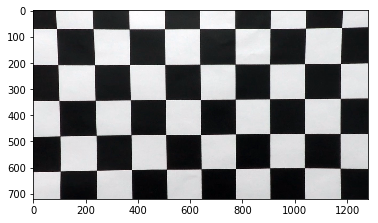

In [16]:
undist = cv2.undistort(img, mtx, dist, None, mtx)
plt.imshow(undist)

In [17]:
# Looks pretty good to my eye!
# Let's apply it to the actual test_image.png provided,
# loaded and displayed here:

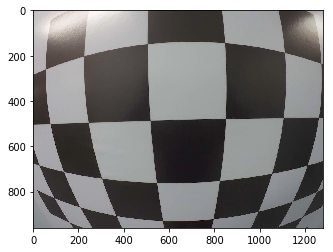

In [18]:
img = cv2.imread('camera_cal/test_image.png')
plt.imshow(img)

In [19]:
# And now with our Camera matrix and distortion coefficients 
# applied via undistort():

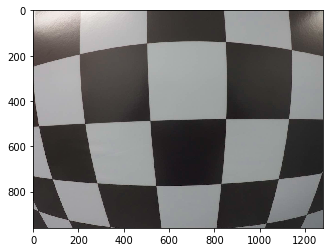

In [20]:
undist = cv2.undistort(img, mtx, dist, None, mtx)
plt.imshow(undist)

In [ ]:
# One's first reaction at seeing this undistorted version of 
# test_image.png is naturally disappointment, as it is much less of 
# a dramatic and obvious correction as compared to the first 
# test image above.
#
# "Does my pipeline not actually work?" I wondered.
#
# But then I realized, "It may have worked, it's just that 
# there's perhaps even more distortion beyond what our numbers 
# can correct for, due to the way the chessboard was photographed 
# most likely (viz. with even greater proximity.)"
#
# Which, of course, made me think about the mysterious 
# fifth distortion co-efficient k_3! 
# Could that be what's needed here, to really 
# straighten out this situation?!  : )
#
# Or, wait... maybe k_3 is already in the mix here,
# and it's just back to my original point: there are effects of 
# this camera / this shoot that are essentially overwhelming
# the undist() algorithm (fed with our numbers), even though
# it *is* actually working, and as expected...
#
# In any case, I have no desire to chase this down right now.
# My pipeline is obviously working on my given test set,
# so I'm moving on, happily... ; )

In [22]:
# Let's move on to creating a stacked combination of 
# binary thresholding the S (Saturation) channel of the HLS color space and
# binary thresholding the result of applying the Sobel operator in the x direction
# on the original image, as shown in Lesson 17, sub-Lesson 12: Color and Gradient
# (Note: all of the code, as well as the general approach - that is, the combination
# of this particular color channel and gradient process - in this part of the pipeline
# is cribbed directly from the aforementioned sub-Lesson.)

In [25]:
# Convert to HLS color space and separate the S channel
hls = cv2.cvtColor(undist, cv2.COLOR_RGB2HLS)
s_channel = hls[:,:,2]

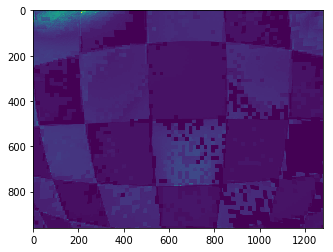

In [26]:
# Let's take a peek at our Saturation channel image...
plt.imshow(s_channel)

In [27]:
# Grayscale the image
gray = cv2.cvtColor(undist, cv2.COLOR_RGB2GRAY)

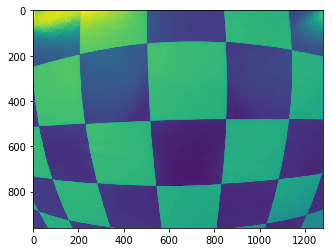

In [28]:
# Check our work
plt.imshow(gray)

In [29]:
# The directions at this point include this note:
#
# NOTE: we already saw that standard grayscaling lost color information for the lane lines
# Explore gradients in other colors spaces / color channels to see what might work better
#
# I must admit I'm not totally clear on why we are grayscaling the image
# if the Instructor thinks the fact that doing so removes color information
# is a problem to be solved here. In any case...

In [30]:
# Sobel x
sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

In [31]:
# Threshold x gradient
thresh_min = 20
thresh_max = 100
sxbinary = np.zeros_like(scaled_sobel)
sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

In [32]:
# Threshold color channel
s_thresh_min = 170
s_thresh_max = 255
s_binary = np.zeros_like(s_channel)
s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1

In [33]:
# Stack each channel to view their individual contributions in green and blue respectively
# This returns a stack of the two binary images, whose components you can see as different colors
color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255

In [34]:
# Combine the two binary thresholds
combined_binary = np.zeros_like(sxbinary)
combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1

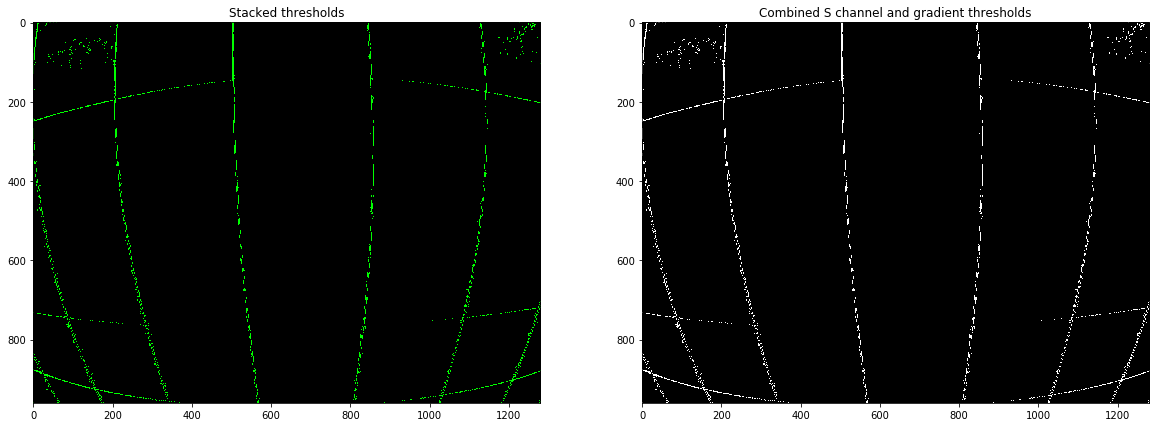

In [37]:
# Plotting thresholded images
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.set_title('Stacked thresholds')
ax1.imshow(color_binary)
ax2.set_title('Combined S channel and gradient thresholds')
ax2.imshow(combined_binary, cmap='gray')

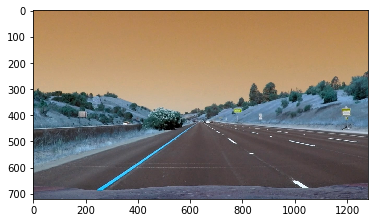

In [40]:
# Cool stuff!  : )

# Let's repeat the above process with a road image
img = cv2.imread('test_images/straight_lines1.jpg')
plt.imshow(img)

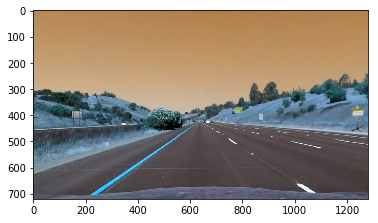

In [41]:
# Undistort it
undist = cv2.undistort(img, mtx, dist, None, mtx)
plt.imshow(undist)

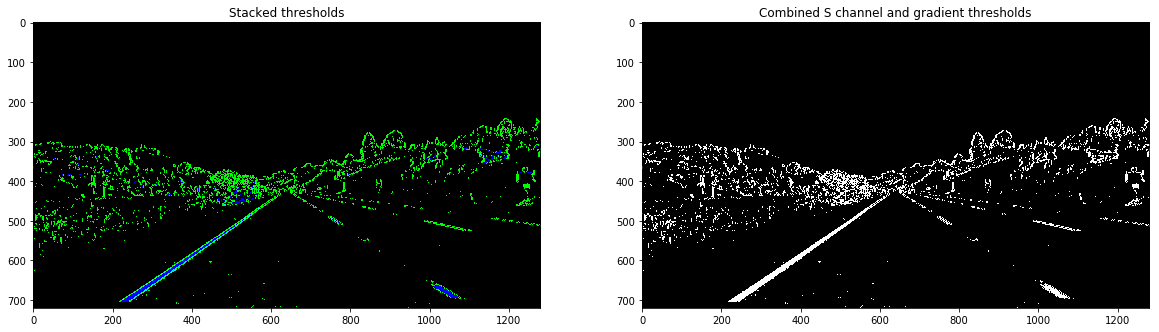

In [42]:
# Convert to HLS color space and separate the S channel
hls = cv2.cvtColor(undist, cv2.COLOR_RGB2HLS)
s_channel = hls[:,:,2]

# Grayscale image
# NOTE: we already saw that standard grayscaling lost color information for the lane lines
# Explore gradients in other colors spaces / color channels to see what might work better
gray = cv2.cvtColor(undist, cv2.COLOR_RGB2GRAY)

# Sobel x
sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

# Threshold x gradient
thresh_min = 20
thresh_max = 100
sxbinary = np.zeros_like(scaled_sobel)
sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

# Threshold color channel
s_thresh_min = 170
s_thresh_max = 255
s_binary = np.zeros_like(s_channel)
s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1

# Stack each channel to view their individual contributions in green and blue respectively
# This returns a stack of the two binary images, whose components you can see as different colors
color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255

# Combine the two binary thresholds
combined_binary = np.zeros_like(sxbinary)
combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1

# Plotting thresholded images
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.set_title('Stacked thresholds')
ax1.imshow(color_binary)
ax2.set_title('Combined S channel and gradient thresholds')
ax2.imshow(combined_binary, cmap='gray')

In [108]:
# Coooool...  : D

# To begin our Perspective Transform process, we will be manually selecting 4 points from
# our straight_lines1.jpg test image. In sub-Lesson 16: Transform a Stop Sign, the Instructor
# uses %matplotlib qt in order to open the image in another window, which allows them to inspect 
# the x,y attributes of every pixel in the image via the cursor pointer. 
# (It should be noted that the carnd-term1 environment has to have its version of matplotlib upgraded 
# in order for this option to be available.)
%matplotlib qt
plt.imshow(undist)

In [120]:
# Using the above method, we have picked out the following source points
src = np.float32([[232, 710], [588, 461], [699, 461], [1062, 699]])
# And check our work
print(src)

[[ 232.  710.]
 [ 588.  461.]
 [ 699.  461.]
 [1062.  699.]]


In [121]:
# As our Instructor says, we can "define our desired rectangle plane for the warped image
# and... choose four different points that are where [we] want the source points to end up...
# by just eyeballing a rectangle in that same image" of ours. I thereby select the following
# destination points:
dst = np.float32([[232, 710], [232, 461], [1062, 461], [1062, 699]])

# Note: unlike the Instructor, I keep my first and last Source points as Destination points verbatim.

# And check our work:
print(dst)

[[ 232.  710.]
 [ 232.  461.]
 [1062.  461.]
 [1062.  699.]]


In [122]:
# Now we can compute the perspective transform, M, given our source and destination points:
M = cv2.getPerspectiveTransform(src, dst)

# And one more work check
print(M)

[[-6.70553612e-01 -1.48563733e+00  1.05937039e+03]
 [-1.41446402e-02 -1.71814184e+00  7.61048508e+02]
 [-3.06825167e-05 -2.31513535e-03  1.00000000e+00]]


In [109]:
# We need to grab our image size real quick before using warpPerspective()
img_size = (undist.shape[1], undist.shape[0])

print(img_size)

(1280, 720)


In [97]:
# Lastly, we warp an image using the perspective transform, M:
warped = cv2.warpPerspective(undist, M, img_size, flags=cv2.INTER_LINEAR)

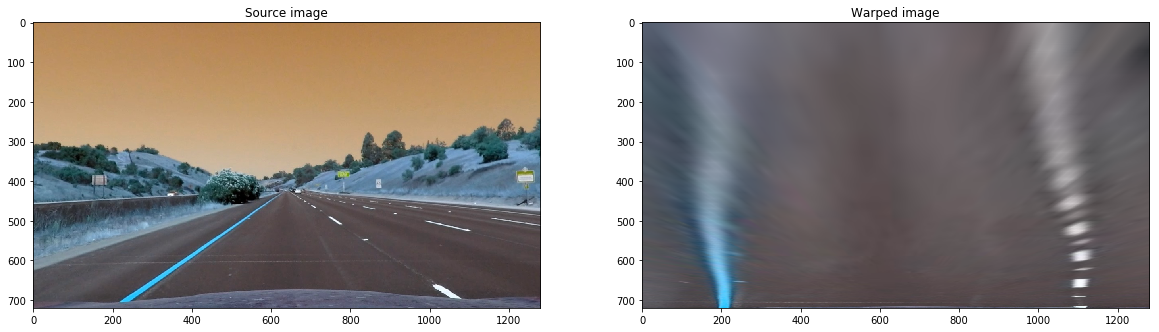

In [112]:
# Let's jump back to inline presentation
%matplotlib inline

# Plotting thresholded images
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.set_title('Source image')
ax1.imshow(undist)
ax2.set_title('Warped image')
ax2.imshow(warped)

In [113]:
# Wow, those Warped image lane lines are not very straight / parallel...
# Hmm... Maybe the lanes / lane lines in the Source image aren't as straight as they seem to be...
# Or maybe there's a reason the Instructor didn't keep any of their original points verbatim...

# Let me try a different set of Source & Destination points 
# and hence a different M matrix...
src = np.float32([[220, 720], [610, 443], [673, 443], [1090, 720]])
dst = np.float32([[220, 720], [220, 443], [1090, 443], [1090, 720]])
M = cv2.getPerspectiveTransform(src, dst)

# And rewarp the image
warped = cv2.warpPerspective(undist, M, img_size, flags=cv2.INTER_LINEAR)

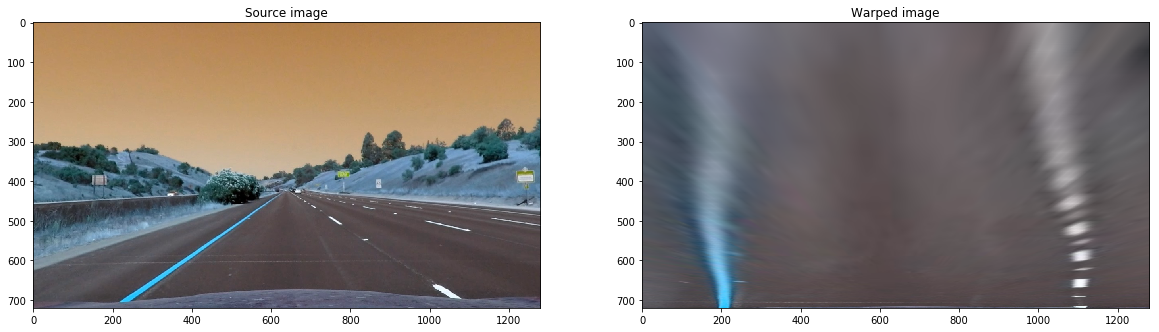

In [114]:
# And let's look at our work again
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.set_title('Source image')
ax1.imshow(undist)
ax2.set_title('Warped image')
ax2.imshow(warped)

In [115]:
# Hmm... not much better.  : /
# 
# (So... sidenote on process: Because the Instructor did not keep any of her Source points
# in her Destination points, I began to take that as some sort of a hint for how I could get
# straighter / more parallel lane lines in my Warped image. However, this massaging parameters
# to produce a more preferential outcome didn't / doesn't sit well with me. Thus, I went back and 
# re-picked the src and dst points, and decided to trust the math more...
#
# And in looking at the Source image again, it is quite clear that - although the lane lines
# in our image are more or less straight - the lane our car is in eventually curves to the
# left. Thus, it is perhaps unsurprising that our Warped image tends slightly to the left, and 
# is in fact perhaps justification for the correctness of our method.
#
# In any case, as mentioned in 18.2: Processing Each Image, "When applying the transform to new images, 
# the test of whether or not you got the transform correct, is that the lane lines should appear parallel 
# in the warped images, whether they are straight or curved," which is more or less the case here...
#
# TODO: apply the above process to the other straight lines image - straight_lines2.jpg?)
#
# For now, let's just apply the above warpPerspective to a test image with more obviously
# curved lane lines...

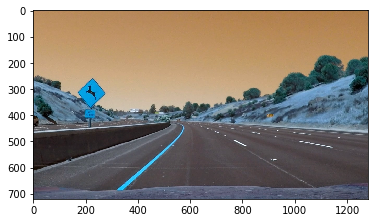

In [116]:
img = cv2.imread('test_images/test2.jpg')
plt.imshow(img)

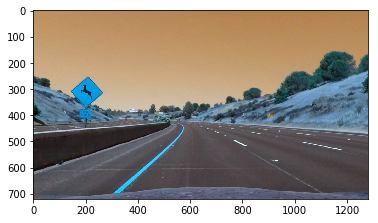

In [117]:
undist = cv2.undistort(img, mtx, dist, None, mtx)
plt.imshow(undist)

In [118]:
warped = cv2.warpPerspective(undist, M, img_size, flags=cv2.INTER_LINEAR)

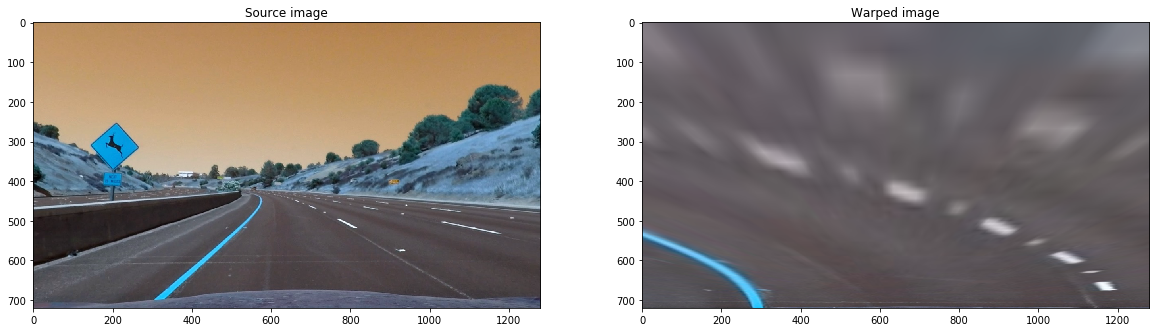

In [119]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.set_title('Source image')
ax1.imshow(undist)
ax2.set_title('Warped image')
ax2.imshow(warped)

In [123]:
# Lol... I mean, I guess it could be worse?...
# And it still seems like the lane lines are more or less parallel...
#
# I'm starting to suspect that our revised points are too ambitious;
# which is to say, I feel like the rectangle we are finagling is too large,
# such that it's having too extreme of a warping effect. Thus, I'm going to 
# try again using our previous measurements and resultant M
#
# WAIT A MINUTE. Hold the phone. In looking at the assets in 18.2, I noticed
# that the Instructor's ideal rectangle is as tall as the original image,
# whereas I had been capping mine at the height of the rectangle I picked
# out of the Source image.
#
# This also explains why the upper sections of my Warped lane lines
# were so fuzzed out compared to the Instructor's results.
#
# I'm going to go back one more time and re-calculate these values:

src = np.float32([[220, 720], [610, 443], [673, 443], [1090, 720]])
dst = np.float32([[220, 720], [220, 0], [1090, 0], [1090, 720]])
M = cv2.getPerspectiveTransform(src, dst)

In [124]:
warped = cv2.warpPerspective(undist, M, img_size, flags=cv2.INTER_LINEAR)

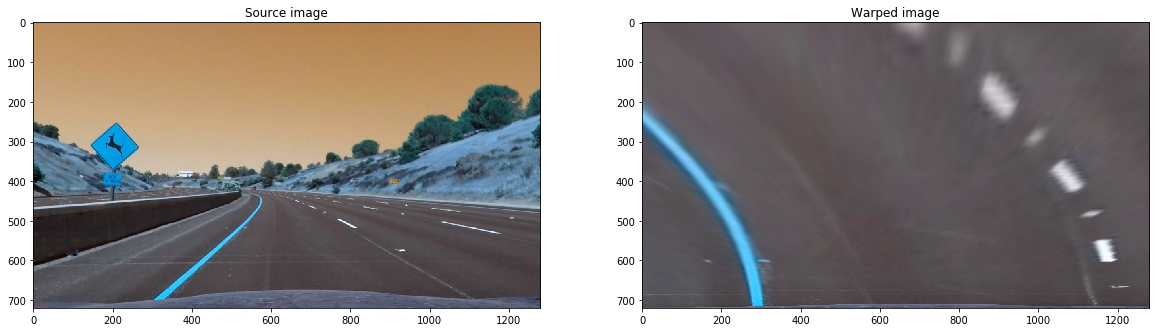

In [125]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.set_title('Source image')
ax1.imshow(undist)
ax2.set_title('Warped image')
ax2.imshow(warped)

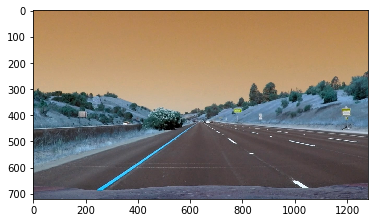

In [127]:
# Ah, that's so much better...
#
# Let me apply this to straight_lines1.jpg just so I can feel better about everything.
img = cv2.imread('test_images/straight_lines1.jpg')
plt.imshow(img)

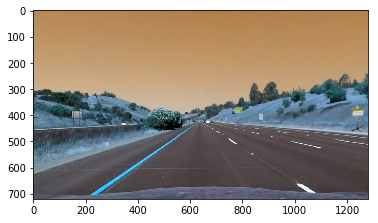

In [128]:
undist = cv2.undistort(img, mtx, dist, None, mtx)
plt.imshow(undist)

In [129]:
warped = cv2.warpPerspective(undist, M, img_size, flags=cv2.INTER_LINEAR)

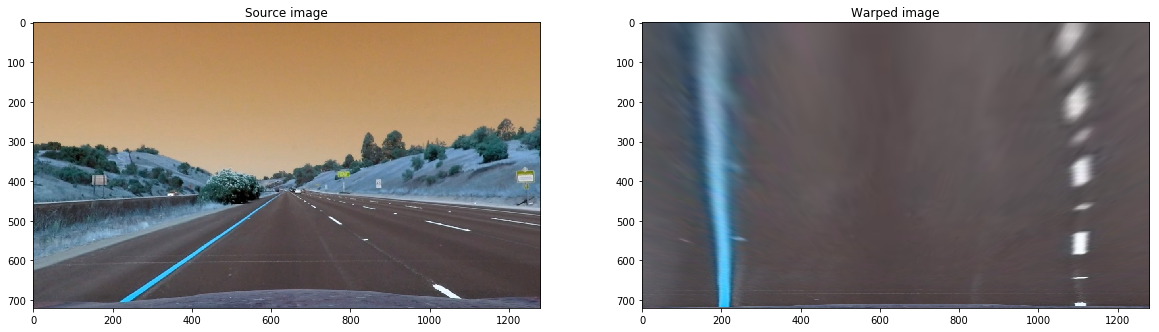

In [130]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.set_title('Source image')
ax1.imshow(undist)
ax2.set_title('Warped image')
ax2.imshow(warped)

In [132]:
# Oh my god, that's so much better!!  : )
# (And still trending to the left, it's worth noting / noticing... ; )
#
# Moving on: For a moment there, I mistakenly thought it might not matter whether or not
# we do the thresholding / binary combining before or after the perspective
# transform, but now I see that it does (probably?) create a very different
# end product... Why am I stating a hypothesis when I could just compare both versions? : )

In [139]:
def make_binary(img):
    # Convert to HLS color space and separate the S channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]

    # Grayscale image
    # NOTE: we already saw that standard grayscaling lost color information for the lane lines
    # Explore gradients in other colors spaces / color channels to see what might work better
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # Sobel x
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

    # Threshold x gradient
    thresh_min = 20
    thresh_max = 100
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    # Threshold color channel
    s_thresh_min = 170
    s_thresh_max = 255
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1

    # Stack each channel to view their individual contributions in green and blue respectively
    # This returns a stack of the two binary images, whose components you can see as different colors
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255

    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    
    return combined_binary

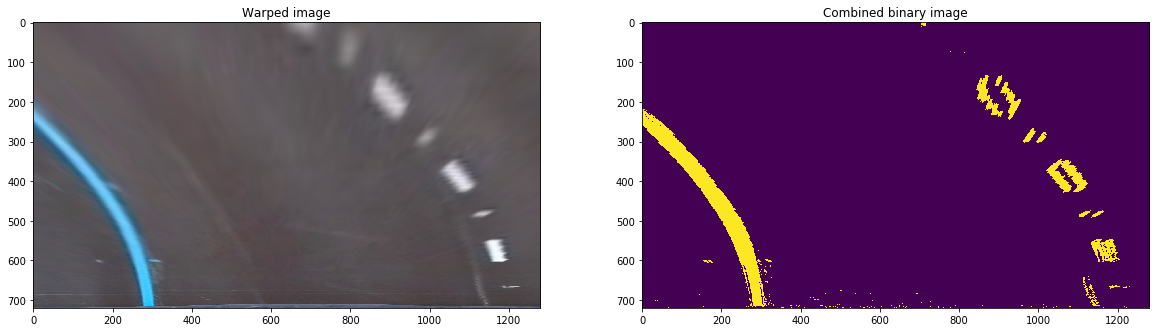

In [136]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.set_title('Warped image')
ax1.imshow(warped)
ax2.set_title('Combined binary image')
ax2.imshow(combined_binary)

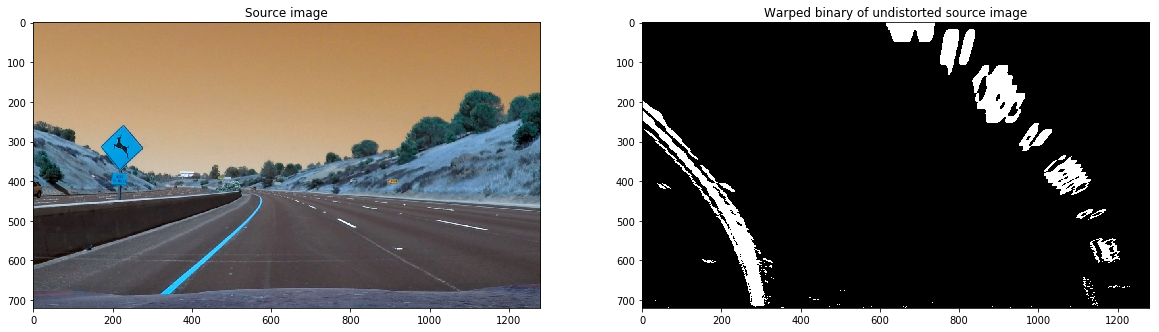

In [144]:
# Oh, yes; of course. We can see right away that the reason why we can't create
# our combined thresholded binaries after Perspective Transform is because the 
# Saturation level of the lane lines is "diluted" by the effects of the PT 
# blurring things that are farther away, such that they drop out of the S channel entirely...
# Thus, no need to continue with the comparison; Binary Creation must happen before Perspective Transform.
#
# Let's start from the top:

# Load image
img = cv2.imread('test_images/test2.jpg')
# Correct for camera distortion
undist = cv2.undistort(img, mtx, dist, None, mtx)
# Make a binary of the undistorted image
binary = make_binary(undist)
# Perspective transform the binary
warped = cv2.warpPerspective(binary, M, img_size, flags=cv2.INTER_LINEAR)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.set_title('Source image')
ax1.imshow(img)
ax2.set_title('Warped binary of undistorted source image')
ax2.imshow(warped, cmap='gray')

In [ ]:
# Ah, yes. Those are much better results... : )  We have the preprocessing part of our pipeline done.